# TP STATC : Etude d'un jeu de données Breast Cancer Wisconsin

### *Guillaume HEGER, Nicolas HUBERT*

Dans ce TP, nous étudions un problème d'apprentissage à partir de données médicales collectées dans le Wisconsin entre 1984 et 1995 (cf. fichier `wpbc.names`).

Il s'agit de prédire si un patient est atteint de cancer de la poitrine à partir d'informations relevées sur une image de cellules de la poitrine.

Pour chaque cellule, 10 paramètres sont donnés, chacun déclinés en 3 statistiques : moyenne, erreur-type et pire cas (mean, se et worst dans les codes suivants).

Il s'agira de voir lesquels de ces facteurs semblent être les plus déterminants.
Dans un premier temps, nous effectuerons une "classification visuelle" en représentant, pour chaque paramètre, les densités séparées pour les patients non atteints et les patients atteints.
Dans un second temps, nous effectuerons **l'analyse des corrélation** ainsi que **l'analyse en composantes principales** de ce jeu de données que nous confronterons avec les résultats intuitifs précédents.
Ensuite, pour que la prédiction soit quantitative, nous effectuerons plusieurs **régressions logistiques** de la variable `outcome` en fonction d'un ou plusieurs régresseurs, en optimisant le choix des régresseurs par critère AIC.
Enfin, nous nous essayerons à l'algorithme **K-Means** pour tenter de prédire la classification de nouveaux patients dans l'une ou l'autre des deux classes référencées.

## Importation des données

Nous importons d'abord les données du fichier `wpbc.data` en nommant les variables d'après ce qui est décrit dans le fichier `wpbc.names`.

In [44]:
wpbc=read.table('wpbc.data',sep=',',na.strings='?') 
# d'après le descriptif 
# il manque 4 données dans le lymph_node_status. On voit qu'elles sont indiquées par un point d'interrogation
features=c(
  'radius',
  'texture',
  'perimeter',
  'area',
  'smoothness',
  'compactness',
  'concavity',
  'concave_points',
  'symmetry',
  'fractal_dimension'
)
stats=c(
  'mean',
  'se',
  'worst'
)
library(magrittr)
library(stringr)
complete_features = NULL
for (stat in stats) {
  eval(parse(text=str_c(stat,'_attributes=NULL'))) # tableau rassemblant les noms portant sur la même stat (mean, se ou worst)
  for (feature in features) {
    complete_features = complete_features %>% c(str_c(stat,'_',feature))
    eval(parse(text=str_c(stat,'_attributes=',stat,'_attributes%>%c("',stat,'_',feature,'")')))
  }
}
colnames(wpbc) <- c(
  'id_number',
  'outcome',
  'time',
  complete_features,
  'tumor_size',
  'lymph_node_status'
)
wpbc%>%head(7)
wpbc%>%summary

id_number,outcome,time,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,...,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,tumor_size,lymph_node_status
119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,...,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,...,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0
843786,R,77,12.75,15.29,84.60,502.7,0.11890,0.1569,0.1664,...,107.30,733.2,0.1706,0.4196,0.5999,0.1709,0.3485,0.11790,2.5,0
844359,N,60,18.98,19.61,124.40,1112.0,0.09087,0.1237,0.1213,...,152.60,1593.0,0.1144,0.3371,0.2990,0.1922,0.2726,0.09581,1.5,NA


   id_number       outcome      time         mean_radius     mean_texture  
 Min.   :   8423   N:151   Min.   :  1.00   Min.   :10.95   Min.   :10.38  
 1st Qu.: 855745   R: 47   1st Qu.: 14.00   1st Qu.:15.05   1st Qu.:19.41  
 Median : 886339           Median : 39.50   Median :17.29   Median :21.75  
 Mean   :1990469           Mean   : 46.73   Mean   :17.41   Mean   :22.28  
 3rd Qu.: 927996           3rd Qu.: 72.75   3rd Qu.:19.58   3rd Qu.:24.66  
 Max.   :9411300           Max.   :125.00   Max.   :27.22   Max.   :39.28  
                                                                           
 mean_perimeter     mean_area      mean_smoothness   mean_compactness 
 Min.   : 71.90   Min.   : 361.6   Min.   :0.07497   Min.   :0.04605  
 1st Qu.: 98.16   1st Qu.: 702.5   1st Qu.:0.09390   1st Qu.:0.11020  
 Median :113.70   Median : 929.1   Median :0.10190   Median :0.13175  
 Mean   :114.86   Mean   : 970.0   Mean   :0.10268   Mean   :0.14265  
 3rd Qu.:129.65   3rd Qu.:1193.5   3r

## Prévalence

In [46]:
library(repr) # recadrage des graphiques sous Jupyter
options(repr.plot.width=6, repr.plot.height=3)

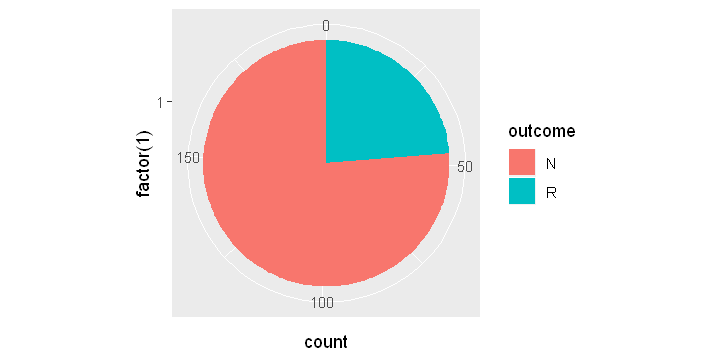

In [47]:
library(ggplot2)
#prévalence
ggplot(wpbc,aes(x=factor(1),fill=outcome)) +
  geom_bar() +
  coord_polar(theta='y')

A titre indicatif, nous représentons ci-dessus la prévalence de la maladie sur un diagramme circulaire. L'échantillon dénombre environ un quart de patients atteints.

## Classification "à la main"

Ici, nous représentons des estimations de densités de chaque variable potentiellement explicatrice en discriminant par la variable outcome.

Ceci permet de se faire une première idée des variables explicatives pour le problème. Celles-ci seront les variables pour lesquelles les distributions observées sont les plus dissemblables.

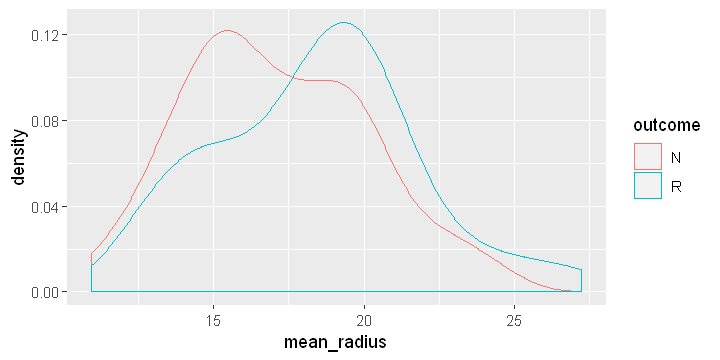

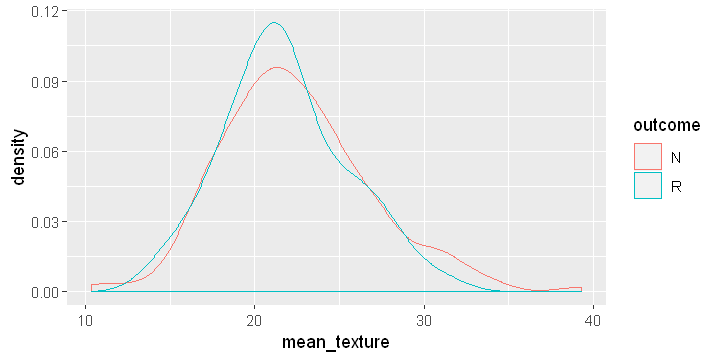

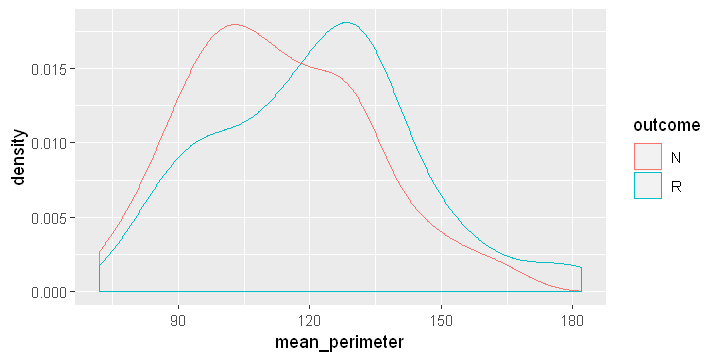

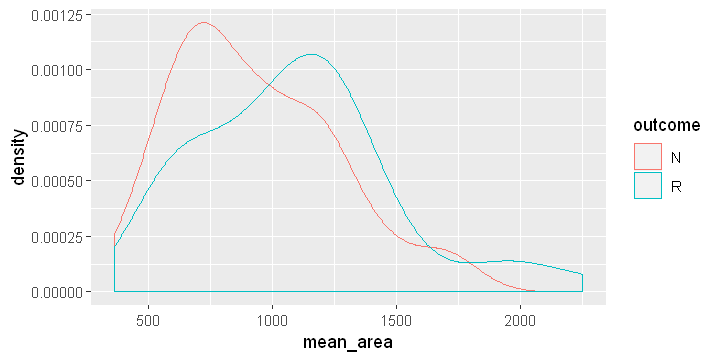

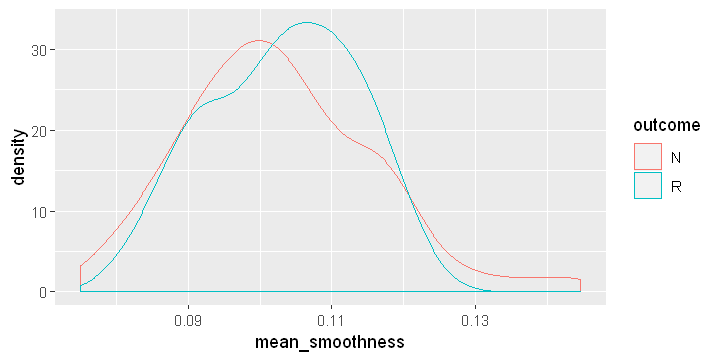

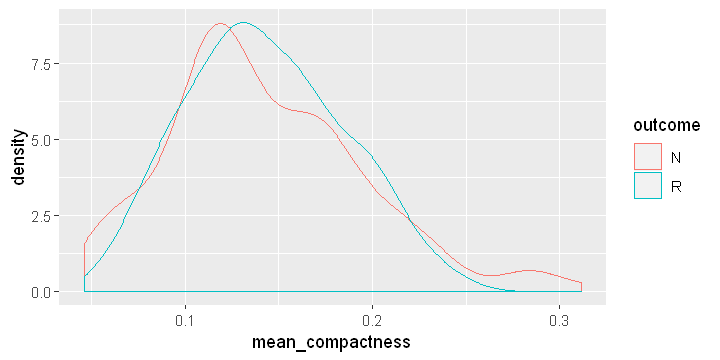

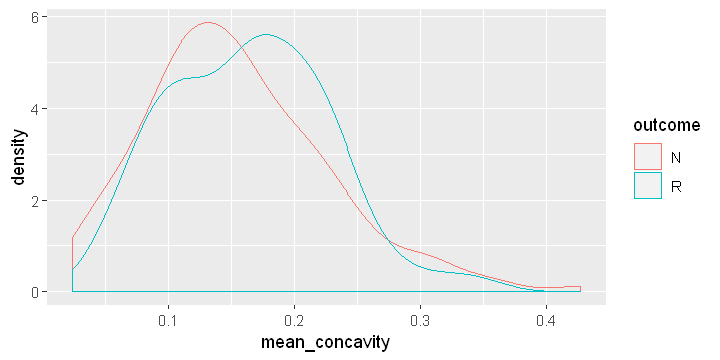

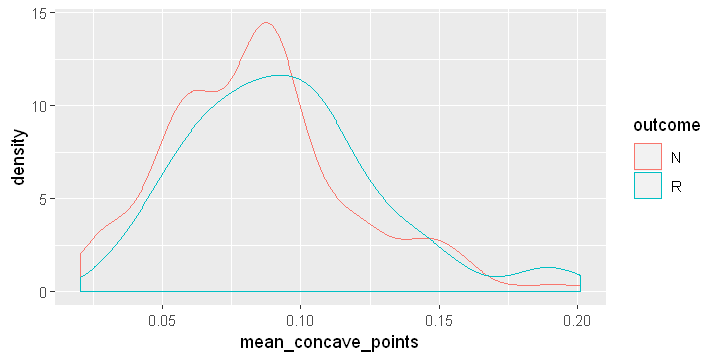

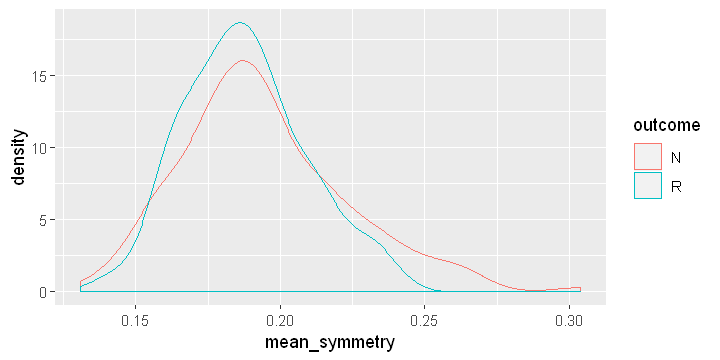

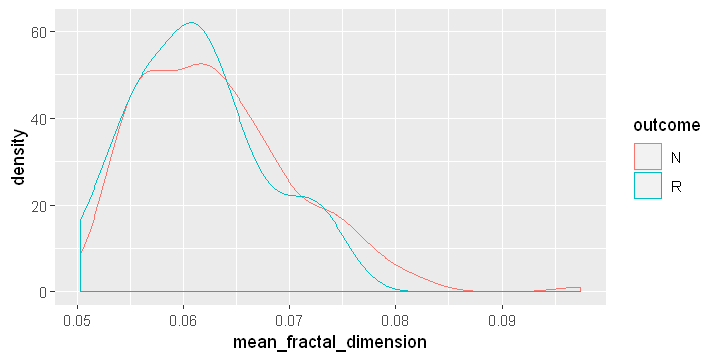

In [4]:
for (feature in mean_attributes) {
  p=ggplot(wpbc)+
    aes_string(x=feature,color='outcome')+
    geom_density()
  plot(p)
}

Nous avons ici représenté les densités associées aux moyennes de chaque paramètre.
Dans la plupart des cas, les distributions sont relativement semblables, à l'exception des paramètres de dimension des cellules (rayon, périmètre et aire, fortement liés entre eux).

Pour comparer les distributions de façon plus systématique, on peut effectuer le **test d'égalité des moyennes de Student** sur les échantillons N et R pour chaque variable. 

On classe ensuite les variables selon leurs p-valeurs (les p-valeurs les plus faibles correspondant aux facteurs les plus discriminants).

In [5]:
attach(wpbc,warn.conflicts=FALSE)
p.values=NULL
for (feature in mean_attributes) {
    eval(parse(text=str_c('p.values=p.values%>%c(t.test(x=',feature,'[which(outcome=="N")],y=',feature,'[which(outcome=="R")])$p.value)')))
}
detach(wpbc)
names(p.values)<-mean_attributes
sort(p.values)

mean_area         mean_perimeter            mean_radius 
            0.01650799             0.02067601             0.02152045 
mean_fractal_dimension          mean_symmetry    mean_concave_points 
            0.08537668             0.09879330             0.10469524 
          mean_texture         mean_concavity        mean_smoothness 
            0.31870412             0.40591783             0.74030550 
      mean_compactness 
            0.98989046

Si on choisit un niveau de significativité de 5%, seuls l'aire, le périmètre et le rayon semblent discriminer en moyenne les individus sains et malades. On retrouve les prédicteurs que l'on avait gardé en comparant visuellement les densités.

Avec un niveau de 10%, on a en plus la dimension fractale et la symétrie.

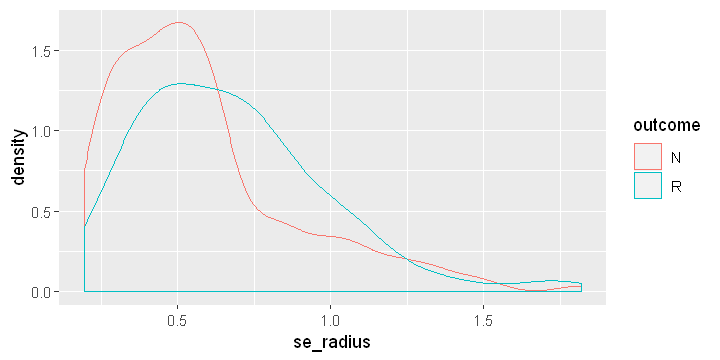

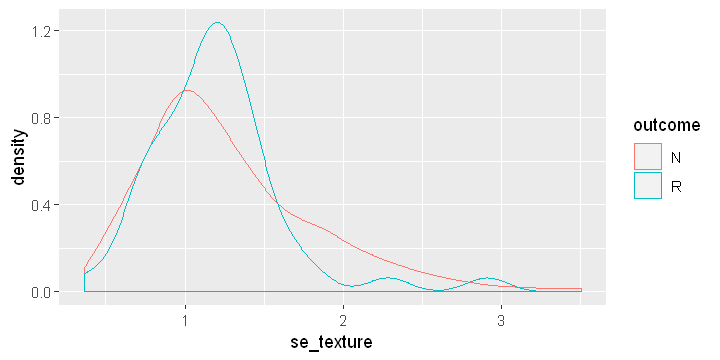

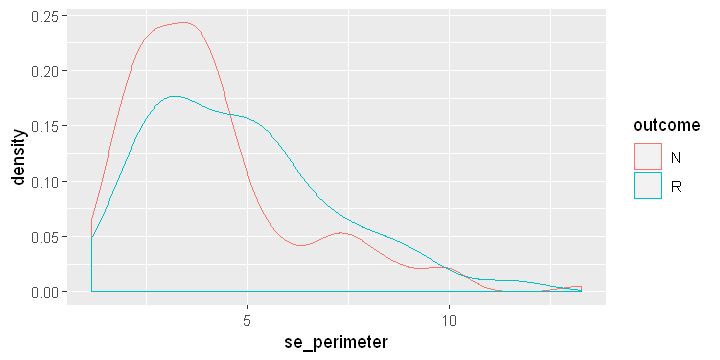

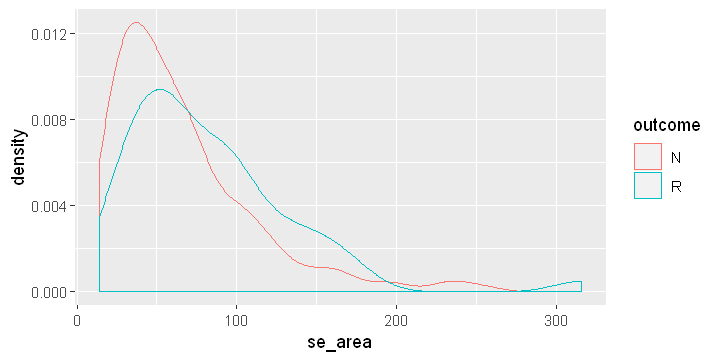

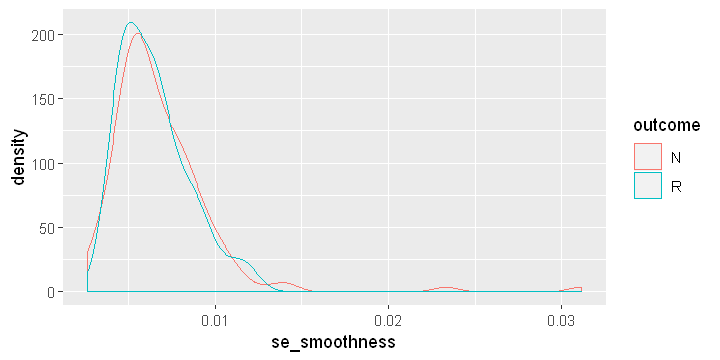

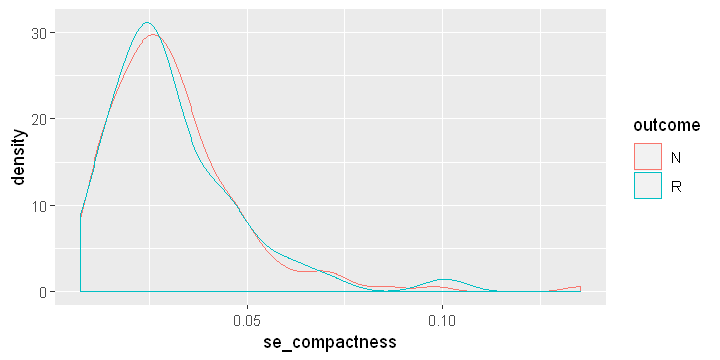

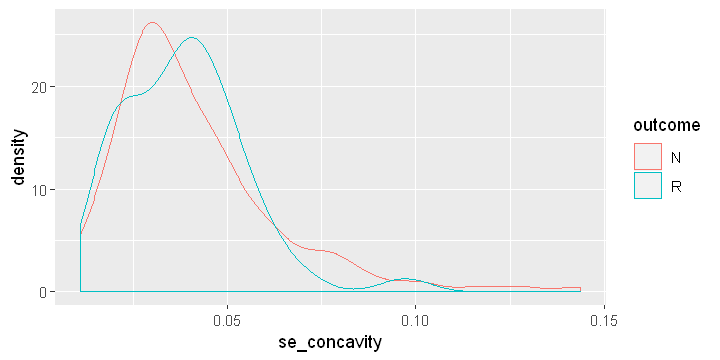

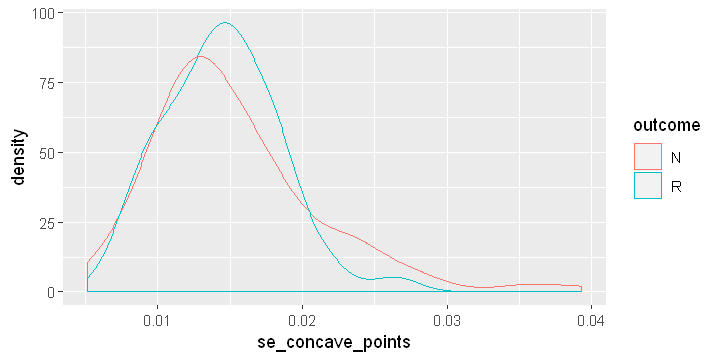

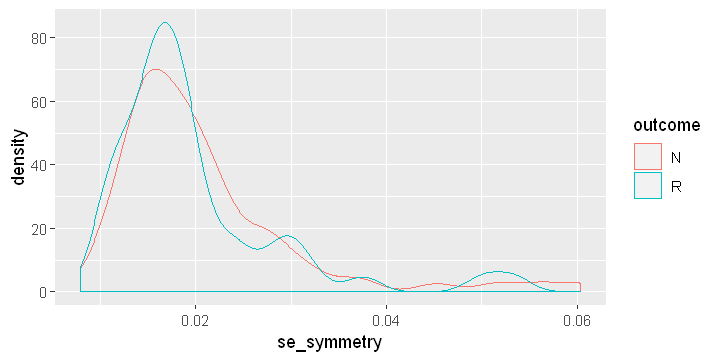

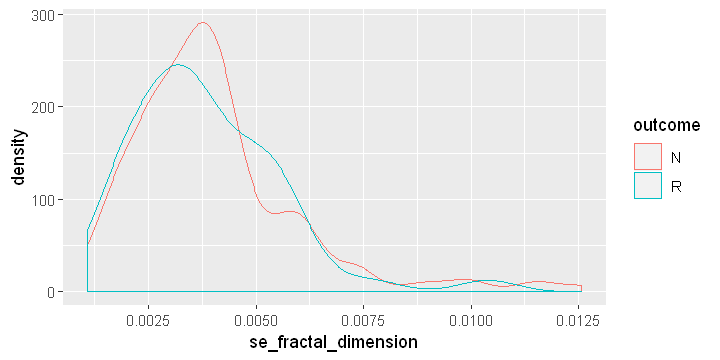

In [6]:
for (feature in se_attributes) {
  p=ggplot(wpbc)+
    aes_string(x=feature,color='outcome')+
    geom_density()
  plot(p)
}

Sur les densités des erreurs-types, les distributions sont très semblables entre les individus atteints et les individus sains. Ceci est conforme à nos attentes, puisque les variables SE sont uniquement liées aux mesures.

In [7]:
attach(wpbc,warn.conflicts=FALSE)
p.values=NULL
for (feature in se_attributes) {
    eval(parse(text=str_c('p.values=p.values%>%c(t.test(x=',feature,'[which(outcome=="N")],y=',feature,'[which(outcome=="R")])$p.value)')))
}
detach(wpbc)
names(p.values)<-se_attributes
sort(p.values)

se_area         se_perimeter            se_radius 
          0.05215484           0.05403386           0.06381469 
          se_texture    se_concave_points         se_concavity 
          0.22247238           0.26042769           0.31859723 
       se_smoothness se_fractal_dimension          se_symmetry 
          0.35171506           0.51754466           0.52163609 
      se_compactness 
          0.89273271

Les tests de Student semblent confirmer ceci, toutes les p-valeurs étant supérieures à 5%.

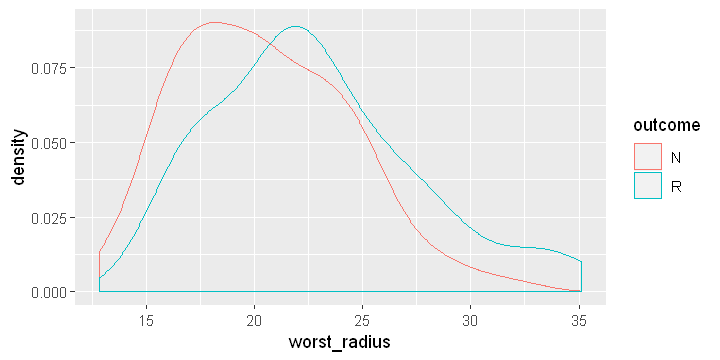

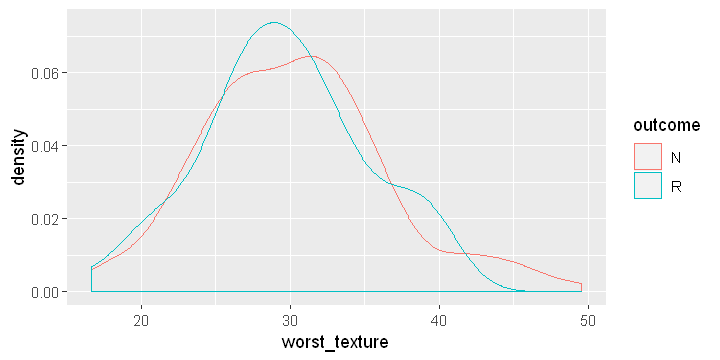

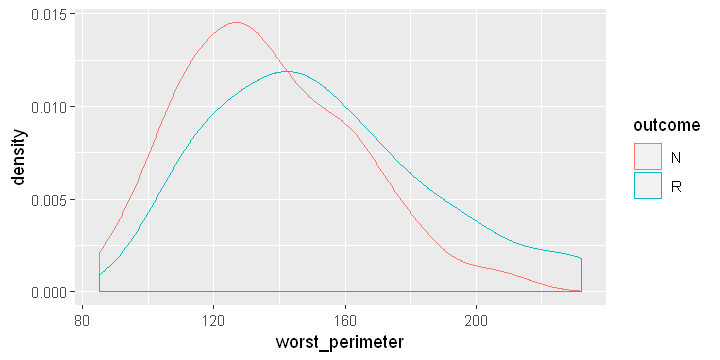

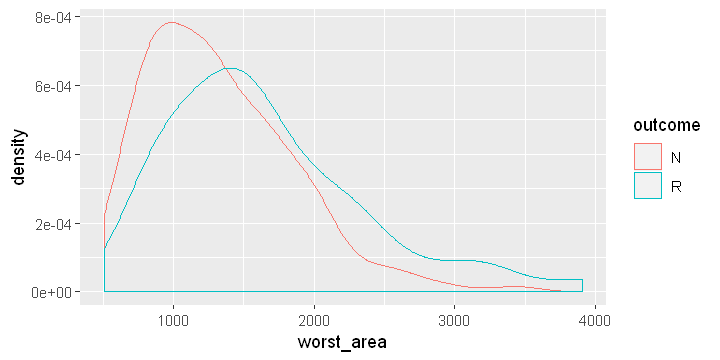

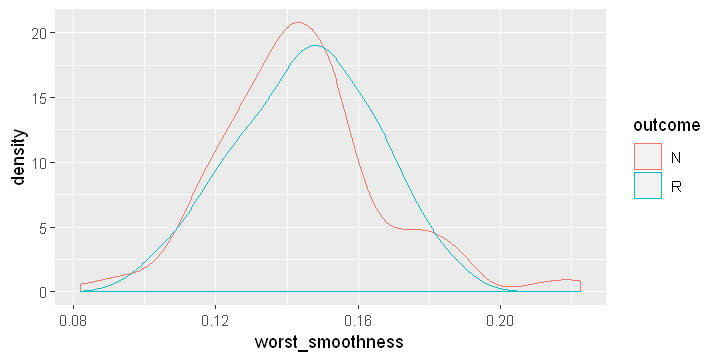

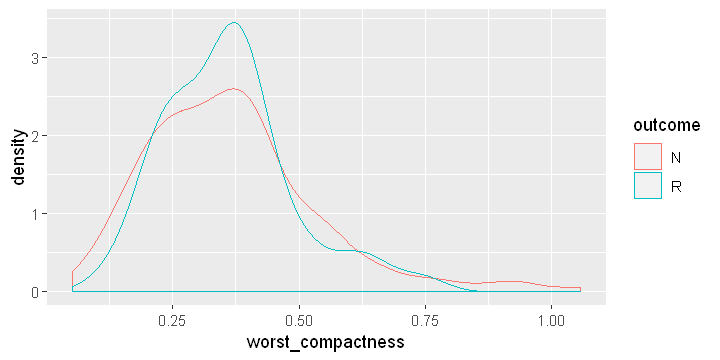

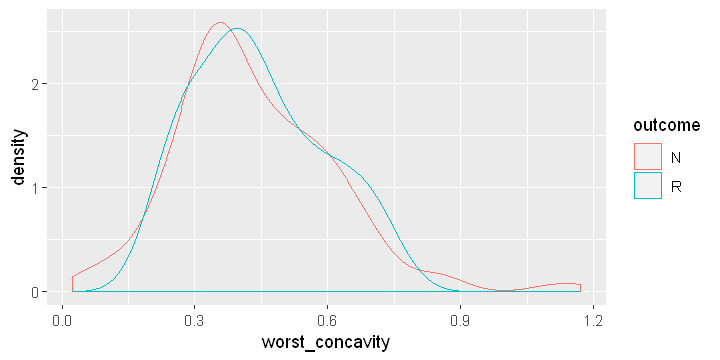

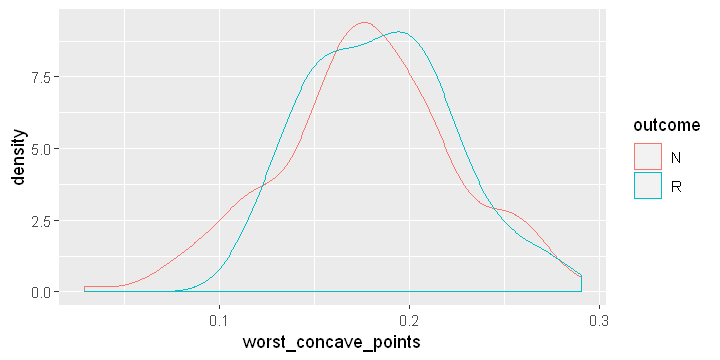

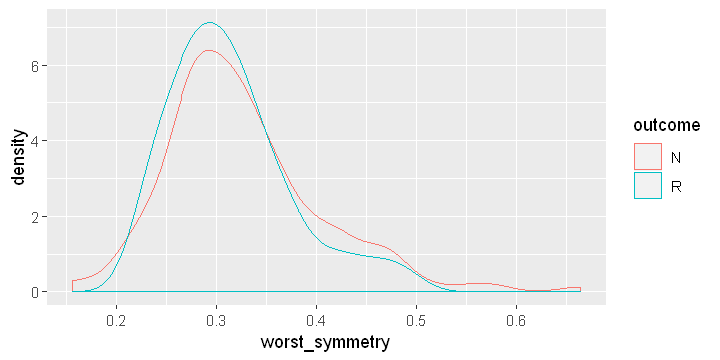

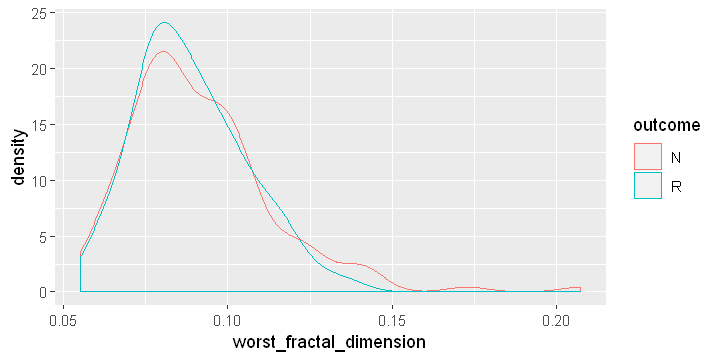

In [8]:
for (feature in worst_attributes) {
  p=ggplot(wpbc)+
    aes_string(x=feature,color='outcome')+
    geom_density()
  plot(p)
}

In [9]:
attach(wpbc,warn.conflicts=FALSE)
p.values=NULL
for (feature in worst_attributes) {
    eval(parse(text=str_c('p.values=p.values%>%c(t.test(x=',feature,'[which(outcome=="N")],y=',feature,'[which(outcome=="R")])$p.value)')))
}
detach(wpbc)
names(p.values)<-worst_attributes
sort(p.values)

worst_radius         worst_perimeter              worst_area 
            0.003255086             0.003880188             0.005018880 
         worst_symmetry    worst_concave_points worst_fractal_dimension 
            0.232915625             0.245400688             0.368504837 
          worst_texture        worst_smoothness       worst_compactness 
            0.448165785             0.558517988             0.744586763 
        worst_concavity 
            0.783359051

Encore une fois, seuls les variables dimensionnelles semblent discriminer (efficacement car p<1%) les patients sains et malades.

On s'intéresse désormais aux relations entretenues entre les variables elles-mêmes. Pour visualiser les relations entre tous les prédicteurs possibles, on a recours à la matrice de corrélation :

In [10]:
# On supprime la colonne ID qui, a priori, ne nous sera d'aucune utilité
wpbc <- wpbc[,-c(0:1)]
head(wpbc)

outcome,time,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,tumor_size,lymph_node_status
N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,0.07055,...,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,0.08180,...,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0
R,77,12.75,15.29,84.60,502.7,0.11890,0.1569,0.1664,0.07666,...,107.30,733.2,0.1706,0.4196,0.5999,0.1709,0.3485,0.11790,2.5,0


In [11]:
wpbc$lymph_node_status<-as.factor(wpbc$lymph_node_status)
is.factor(wpbc$lymph_node_status)

[1] TRUE

In [12]:
wpbc.numeric <- wpbc[sapply(wpbc, is.numeric)]
Corr <- cor(wpbc[sapply(wpbc, is.numeric)])
head(Corr)

,time,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,tumor_size
time,1.0000000,-0.3447224,-0.2646714,-0.3460798,-0.3440312,0.1647929,0.00999965,-0.13947459,-0.171840906,0.177310528,...,-0.17112496,-0.28059569,-0.2539297,0.2127689,0.120516335,0.009545949,-0.02654088,0.2476776,0.28871497,-0.13335545
mean_radius,-0.3447224,1.0000000,0.1434556,0.9959326,0.9928553,-0.1582388,0.15901732,0.46951847,0.664009633,-0.051610176,...,-0.03943905,0.91505258,0.8914887,-0.3728941,-0.150712147,0.038952196,0.35786857,-0.2321419,-0.41433997,0.17210162
mean_texture,-0.2646714,0.1434556,1.0000000,0.1420332,0.1404403,-0.1922625,-0.03980264,0.03716451,0.006686966,-0.165165644,...,0.86204986,0.12367353,0.1174670,-0.1133077,-0.006466665,0.013635101,-0.06992094,-0.1868505,-0.08584727,0.02707288
mean_perimeter,-0.3460798,0.9959326,0.1420332,1.0000000,0.9906988,-0.1029122,0.23672135,0.53319434,0.712765730,-0.006511754,...,-0.03972801,0.92365889,0.8893443,-0.3316669,-0.092040679,0.096790071,0.40999957,-0.2069495,-0.36402219,0.16648922
mean_area,-0.3440312,0.9928553,0.1404403,0.9906988,1.0000000,-0.1414699,0.16317576,0.47586163,0.667529918,-0.060784929,...,-0.03212197,0.92533470,0.9141664,-0.3451107,-0.141357747,0.046640600,0.36502624,-0.2342941,-0.39502574,0.17449061
mean_smoothness,0.1647929,-0.1582388,-0.1922625,-0.1029122,-0.1414699,1.0000000,0.66655885,0.62386703,0.545733704,0.540761345,...,-0.10617242,-0.06466422,-0.1066909,0.7453995,0.447848535,0.499438050,0.53101519,0.3089642,0.53575064,-0.08437631


Le nombre important de variables nuit à la lecture de la matrice de corrélation. Mettons-là en forme afin de mettre en évidence les corrélations les plus notables entre nos variables :

corrplot 0.84 loaded


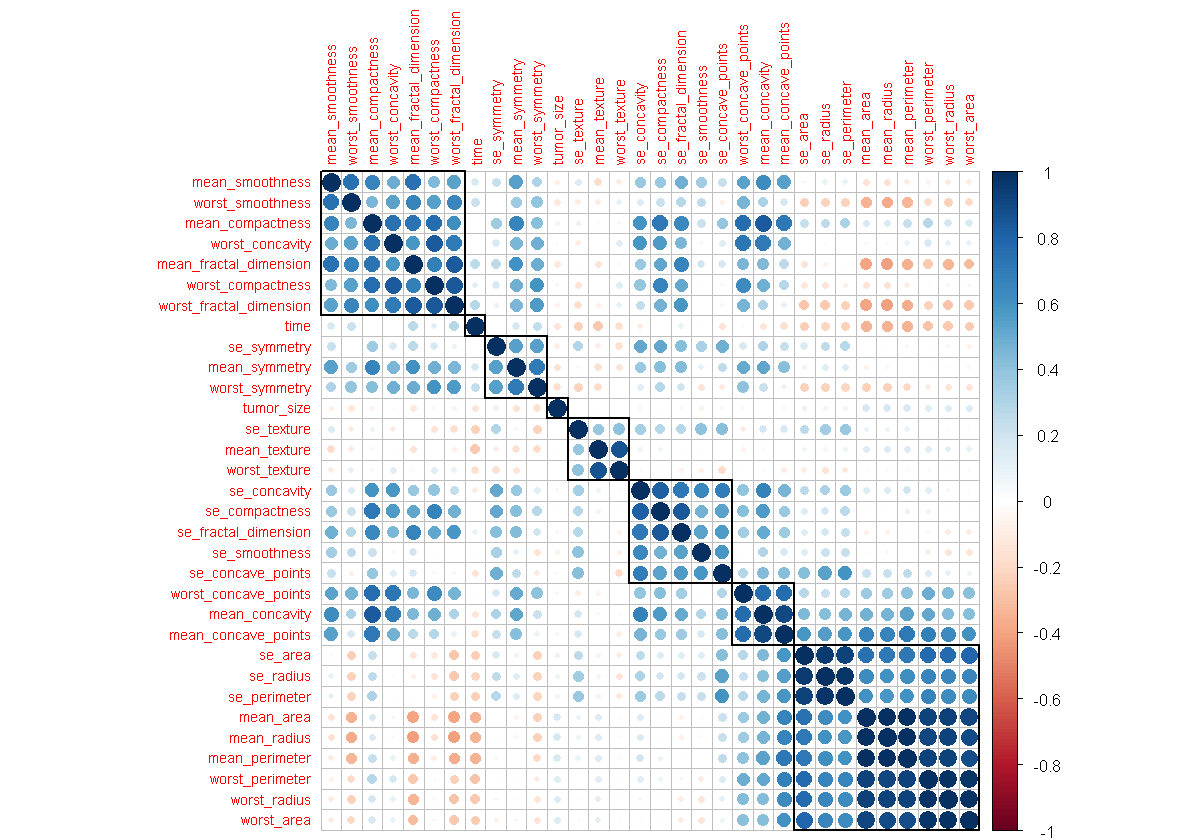

In [13]:
library(corrplot)
options(repr.plot.width=10, repr.plot.height=7)

corrplot(Corr,order = "hclust", tl.cex = 0.7, addrect = 8)
options(repr.plot.width=6, repr.plot.height=4)

Comme on pouvait s'y attendre, la corrélation est très forte entre les variables dimensionnelles. Mais c'est aussi plus généralement le cas de nombreuses variables qui sont fortement (positivement) corrélées. Très souvent, garder autant de variables n'est alors pas judicieux puisque l'on travaille aves des informations redondantes. En éliminant les variables fortement corrélées - ce que l'on fait ci-dessous - on se prémunit d'un biais trop important contenu dans ces variables. On supprime ainsi toutes les variables explicatives ayant une corrélation supérieure à 0.7 :

In [14]:
library(caret)
highlyCor <- colnames(wpbc)[findCorrelation(Corr, cutoff = 0.7, verbose = TRUE)]

Loading required package: lattice


Compare row 8  and column  9 with corr  0.91 
  Means:  0.436 vs 0.302 so flagging column 8 
Compare row 9  and column  7 with corr  0.716 
  Means:  0.402 vs 0.294 so flagging column 9 
Compare row 7  and column  11 with corr  0.735 
  Means:  0.378 vs 0.287 so flagging column 7 
Compare row 11  and column  31 with corr  0.839 
  Means:  0.364 vs 0.281 so flagging column 11 
Compare row 29  and column  28 with corr  0.726 
  Means:  0.329 vs 0.278 so flagging column 29 
Compare row 4  and column  5 with corr  0.991 
  Means:  0.356 vs 0.27 so flagging column 4 
Compare row 5  and column  2 with corr  0.993 
  Means:  0.335 vs 0.265 so flagging column 5 
Compare row 2  and column  15 with corr  0.711 
  Means:  0.307 vs 0.259 so flagging column 2 
Compare row 14  and column  15 with corr  0.93 
  Means:  0.333 vs 0.255 so flagging column 14 
Compare row 15  and column  24 with corr  0.776 
  Means:  0.288 vs 0.251 so flagging column 15 
Compare row 31  and column  27 with corr  0.847 


In [15]:
highlyCor

[1] "mean_compactness"     "mean_concavity"       "mean_smoothness"     
 [4] "mean_symmetry"        "worst_concavity"      "mean_texture"        
 [7] "mean_perimeter"       "time"                 "se_texture"          
[10] "se_perimeter"         "worst_symmetry"       "se_fractal_dimension"
[13] "worst_perimeter"      "se_compactness"       "se_symmetry"         
[16] "mean_area"            "worst_smoothness"     "mean_concave_points" 
[19] "worst_radius"

In [16]:
wpbc2 <- wpbc[, which(!colnames(wpbc) %in% highlyCor)]
ncol(wpbc2)

[1] 15

In [17]:
head(wpbc2)

outcome,mean_radius,mean_fractal_dimension,se_radius,se_area,se_smoothness,se_concavity,se_concave_points,worst_texture,worst_area,worst_compactness,worst_concave_points,worst_fractal_dimension,tumor_size,lymph_node_status
N,18.02,0.06333,0.6249,71.55,0.004433,0.03233,0.009854,37.08,1436.0,0.1926,0.1170,0.08113,5.0,5
N,17.99,0.07871,1.0950,153.40,0.006399,0.05373,0.015870,17.33,2019.0,0.6656,0.2654,0.11890,3.0,2
N,21.37,0.06010,0.5854,82.15,0.006167,0.03300,0.018050,20.98,1949.0,0.3449,0.2032,0.09067,2.5,0
N,11.42,0.09744,0.4956,27.23,0.009110,0.05661,0.018670,26.50,567.7,0.8663,0.2575,0.17300,2.0,0
R,20.29,0.05883,0.7572,94.44,0.011490,0.05688,0.018850,16.67,1575.0,0.2050,0.1625,0.07678,3.5,0
R,12.75,0.07164,0.3877,30.85,0.007775,0.04561,0.013570,20.37,733.2,0.4196,0.1709,0.11790,2.5,0


On a ainsi déjà réduit notre nombre de variables à 15. Ce travail préliminaire est éminemment important pour la suite : il nous permettra de comparer l'efficacité de nos algorithmes de ML sur plusieurs modèles, dont certains auront un nombre de variables de départ plus restreint.

## Analyse en composantes principales

Un nombre trop conséquent de variable peut causer les problèmes suivants :


- Difficulté à visualiser les données
- Rend plus complexe l'interprétation des résultats
- Baisse de l'efficacité analytique et algorithmique en incluant des variables sans effet significatif

L'un des moyens d'y remédier est de procéder par une ACP, ce que l'on fait ci-dessous:

In [18]:
library(FactoMineR)
library(factoextra)
wpbc$lymph_node_status<-as.numeric(wpbc$lymph_node_status)
wpbc_bis=wpbc[-which(sapply(wpbc$lymph_node_status,is.na)),]
pca = PCA(wpbc_bis,quali.sup=c(1,2,3)) #Principal Component Analysis
eigen=get_eig(pca)
eigen

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


,eigenvalue,variance.percent,cumulative.variance.percent
Dim.1,9.4500995784,30.484192188,30.48419
Dim.2,7.6593025669,24.707427635,55.19162
Dim.3,3.3209942646,10.712884724,65.90450
Dim.4,2.2470073831,7.248410913,73.15292
Dim.5,1.5467573617,4.989539876,78.14246
Dim.6,1.4043993974,4.530320637,82.67278
Dim.7,1.1567291017,3.731384199,86.40416
Dim.8,0.9403617043,3.033424853,89.43759
Dim.9,0.5866800982,1.892516446,91.33010
Dim.10,0.4863980147,1.569025854,92.89913


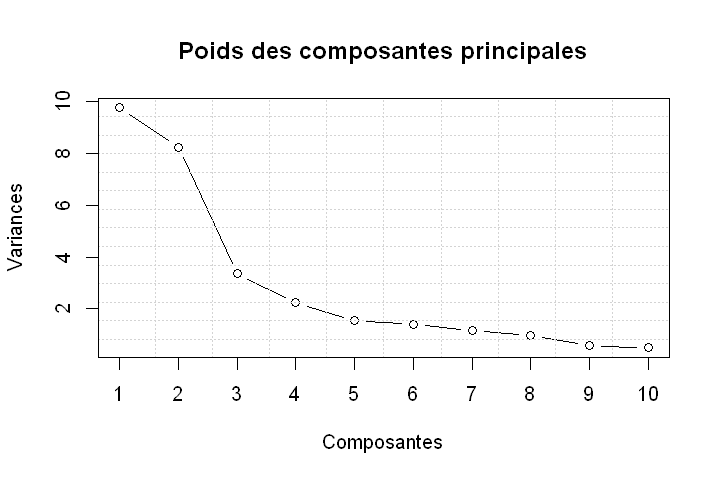

In [19]:
pca <- prcomp(wpbc_bis[, 3:34], center = TRUE, scale = TRUE)
plot(pca, type="l", main='')
grid(nx = 10, ny = 14)
title(main = "Poids des composantes principales", sub = NULL, xlab = "Composantes")
box()

In [20]:
summary(pca)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5    PC6     PC7
Standard deviation     3.1225 2.8714 1.8300 1.49914 1.24380 1.1879 1.08238
Proportion of Variance 0.3047 0.2577 0.1047 0.07023 0.04835 0.0441 0.03661
Cumulative Proportion  0.3047 0.5623 0.6670 0.73723 0.78557 0.8297 0.86628
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.98498 0.76602 0.70228 0.66122 0.60908 0.57245 0.49707
Proportion of Variance 0.03032 0.01834 0.01541 0.01366 0.01159 0.01024 0.00772
Cumulative Proportion  0.89660 0.91493 0.93035 0.94401 0.95560 0.96584 0.97356
                         PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.4491 0.34719 0.32544 0.28135 0.27073 0.22699 0.21220
Proportion of Variance 0.0063 0.00377 0.00331 0.00247 0.00229 0.00161 0.00141
Cumulative Proportion  0.9799 0.98363 0.98694 0.98942 0.99171 0.99332 0.99472
                          PC22    PC23    PC24

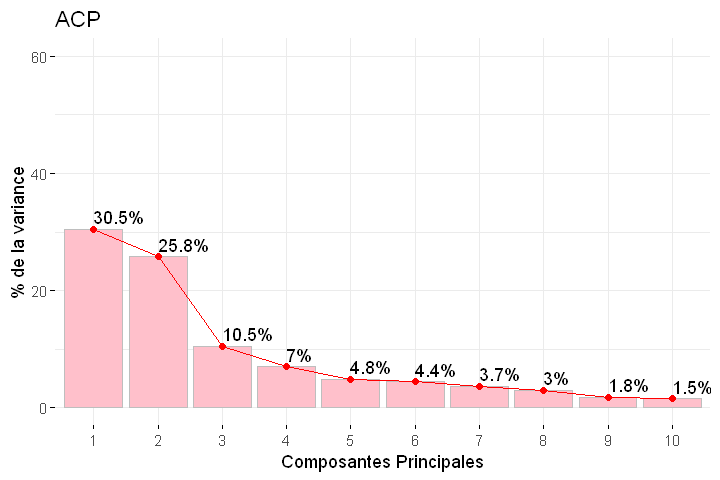

In [21]:
fviz_eig(pca, addlabels=TRUE, ylim=c(0,60), geom = c("bar", "line"), barfill = "pink", barcolor="grey",linecolor = "red", ncp=10)+
labs(title = "ACP",
         x = "Composantes Principales", y = "% de la variance")

In [22]:
all_var <- get_pca_var(pca)
all_var

Principal Component Analysis Results for variables
  Name       Description                                    
1 "$coord"   "Coordinates for the variables"                
2 "$cor"     "Correlations between variables and dimensions"
3 "$cos2"    "Cos2 for the variables"                       
4 "$contrib" "contributions of the variables"               

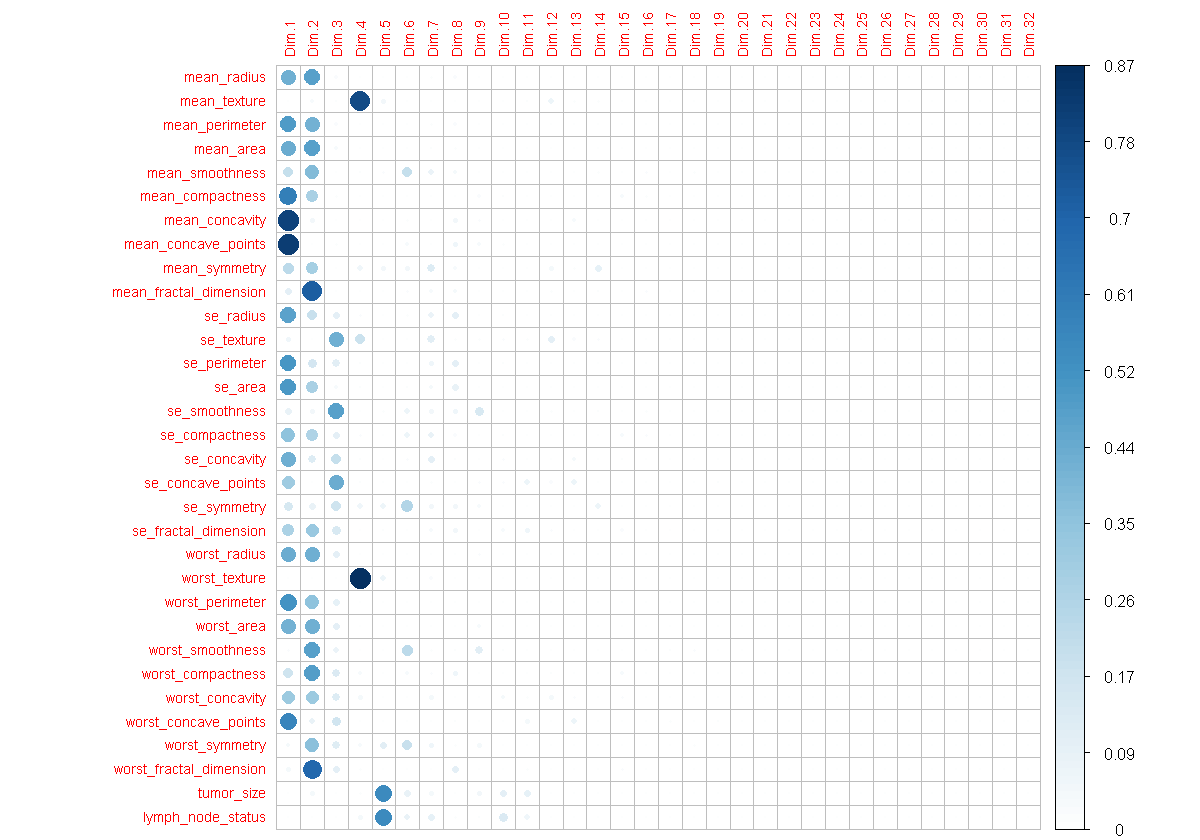

In [23]:
library("corrplot")
options(repr.plot.width=10, repr.plot.height=7)
corrplot(all_var$cos2, is.corr=FALSE, tl.cex = 0.7)

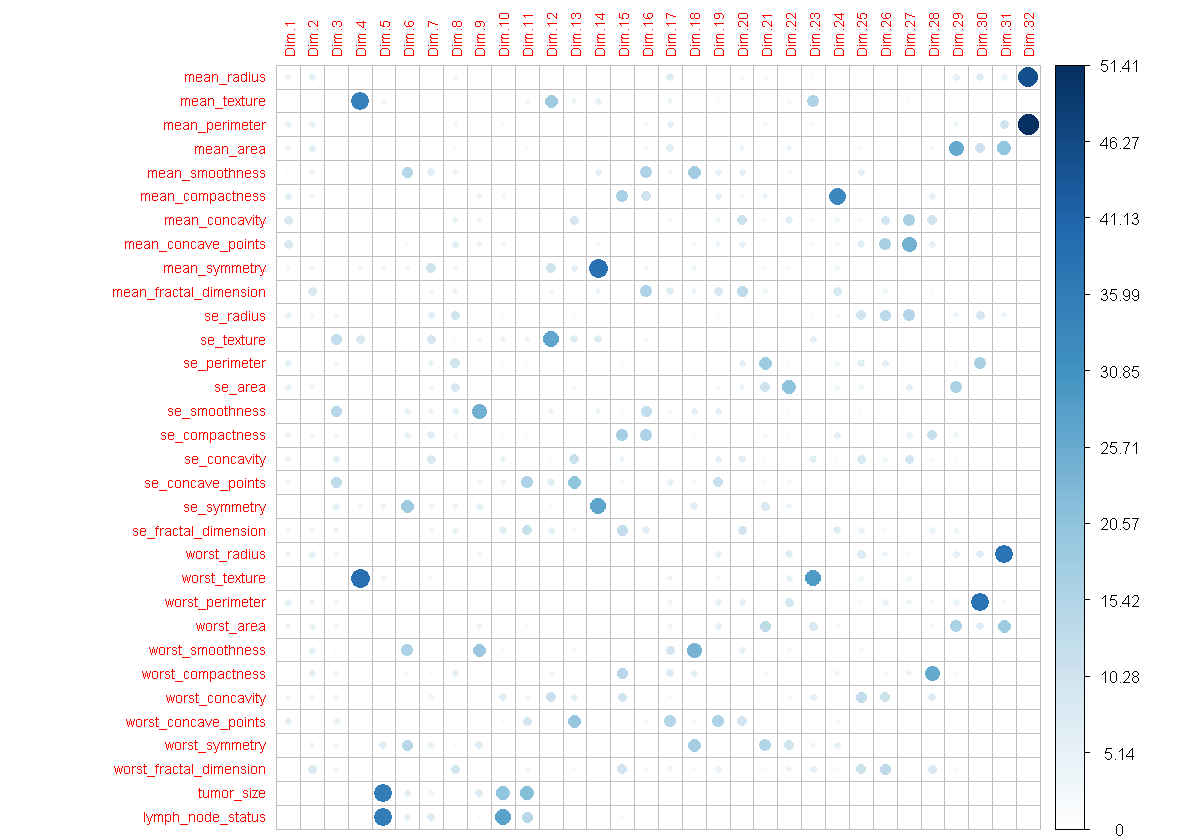

In [24]:
corrplot(all_var$contrib, is.corr=FALSE, tl.cex = 0.7) 

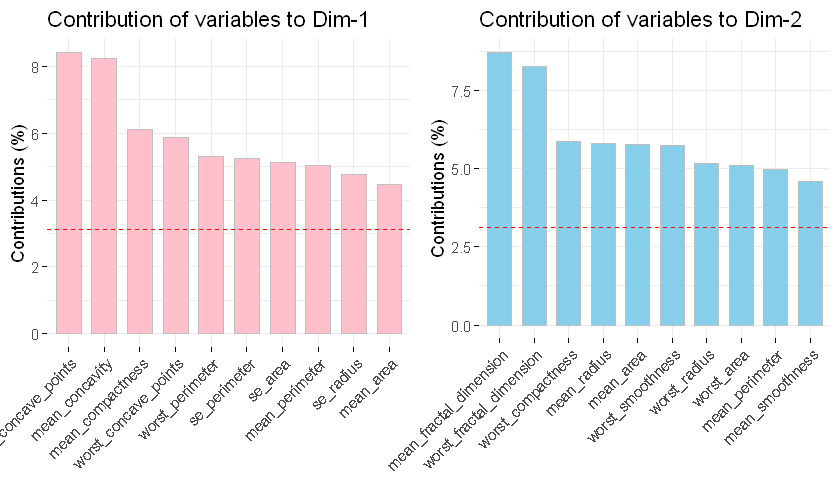

In [25]:
options(repr.plot.width=7, repr.plot.height=4)
library(gridExtra)
p1 <- fviz_contrib(pca, choice="var", axes=1, fill="pink", color="grey", top=10)
p2 <- fviz_contrib(pca, choice="var", axes=2, fill="skyblue", color="grey", top=10)
grid.arrange(p1,p2,ncol=2)

On a ci-dessus une idée assez claire de l'importance des variables pour chacun de nos axes principaux. Cette analyse nous servira par la suite, lorsque l'on souhaiterai effectuer une régression logistiques basée sur notre modèle issu de l'ACP.

Par ailleurs, les trois premières composantes PC1, PC2 et PC3 expliquent à elles trois environ 65% de la variance. Avec 12 variables, on peut expliquer plus de 95% de la variance de la variable outcome à prédire. Réitérons ce même raisonnement, avec cette fois-ci notre second dataset `wpbc2` dont le nombre de variables de départ est inférieur :

In [26]:
ncol(wpbc2)

[1] 15

In [27]:
wpbc2$lymph_node_status<-as.numeric(wpbc2$lymph_node_status)
wpbc_bis2=wpbc2[-which(sapply(wpbc2$lymph_node_status,is.na)),]
head(wpbc_bis2)

outcome,mean_radius,mean_fractal_dimension,se_radius,se_area,se_smoothness,se_concavity,se_concave_points,worst_texture,worst_area,worst_compactness,worst_concave_points,worst_fractal_dimension,tumor_size,lymph_node_status
N,18.02,0.06333,0.6249,71.55,0.004433,0.03233,0.009854,37.08,1436.0,0.1926,0.1170,0.08113,5.0,6
N,17.99,0.07871,1.0950,153.40,0.006399,0.05373,0.015870,17.33,2019.0,0.6656,0.2654,0.11890,3.0,3
N,21.37,0.06010,0.5854,82.15,0.006167,0.03300,0.018050,20.98,1949.0,0.3449,0.2032,0.09067,2.5,1
N,11.42,0.09744,0.4956,27.23,0.009110,0.05661,0.018670,26.50,567.7,0.8663,0.2575,0.17300,2.0,1
R,20.29,0.05883,0.7572,94.44,0.011490,0.05688,0.018850,16.67,1575.0,0.2050,0.1625,0.07678,3.5,1
R,12.75,0.07164,0.3877,30.85,0.007775,0.04561,0.013570,20.37,733.2,0.4196,0.1709,0.11790,2.5,1


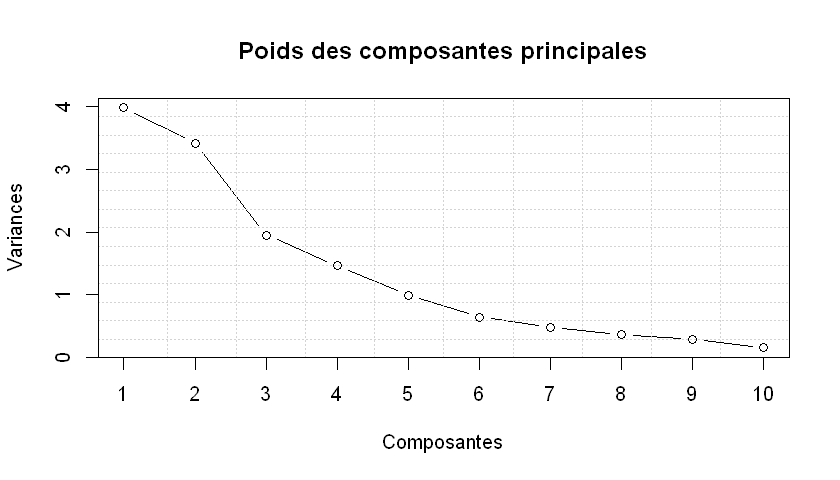

In [28]:
pca2 <- prcomp(wpbc_bis2[, 2:15], center = TRUE, scale = TRUE)
plot(pca2, type="l", main='')
grid(nx = 10, ny = 14)
title(main = "Poids des composantes principales", sub = NULL, xlab = "Composantes")
box()

In [29]:
summary(pca2)

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6    PC7
Standard deviation     1.9951 1.8492 1.3973 1.2096 0.99708 0.80091 0.6960
Proportion of Variance 0.2843 0.2442 0.1394 0.1045 0.07101 0.04582 0.0346
Cumulative Proportion  0.2843 0.5286 0.6680 0.7725 0.84353 0.88935 0.9240
                           PC8     PC9    PC10   PC11   PC12    PC13    PC14
Standard deviation     0.60972 0.53785 0.38976 0.3450 0.2645 0.20925 0.13765
Proportion of Variance 0.02655 0.02066 0.01085 0.0085 0.0050 0.00313 0.00135
Cumulative Proportion  0.95050 0.97117 0.98202 0.9905 0.9955 0.99865 1.00000

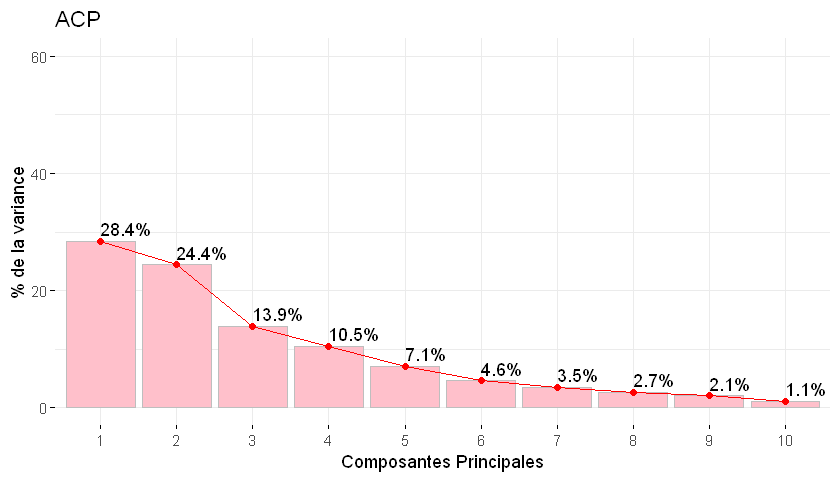

In [30]:
fviz_eig(pca2, addlabels=TRUE, ylim=c(0,60), geom = c("bar", "line"), barfill = "pink", barcolor="grey",linecolor = "red", ncp=10)+
labs(title = "ACP",
         x = "Composantes Principales", y = "% de la variance")

Principal Component Analysis Results for variables
  Name       Description                                    
1 "$coord"   "Coordinates for the variables"                
2 "$cor"     "Correlations between variables and dimensions"
3 "$cos2"    "Cos2 for the variables"                       
4 "$contrib" "contributions of the variables"               

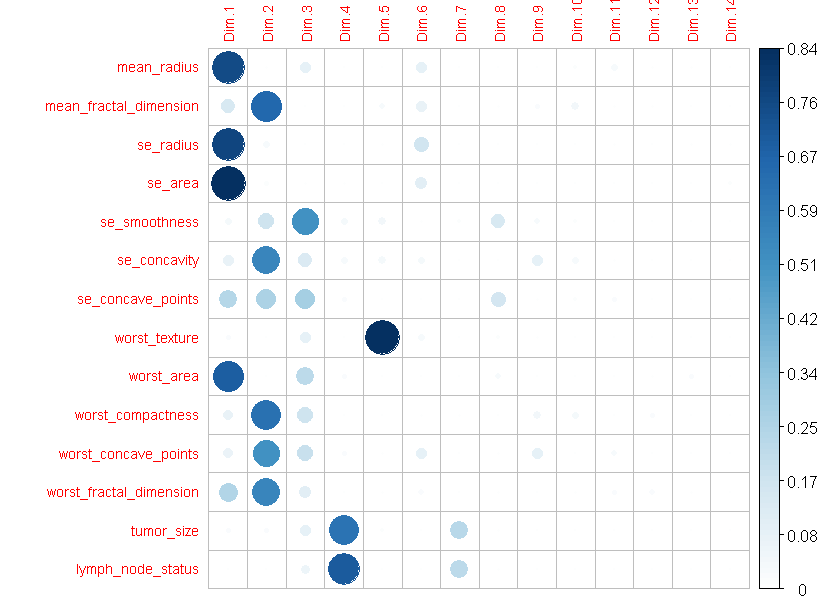

In [31]:
all_var2 <- get_pca_var(pca2)
all_var2
options(repr.plot.width=7, repr.plot.height=5)
corrplot(all_var2$cos2, is.corr=FALSE, tl.cex = 0.7)

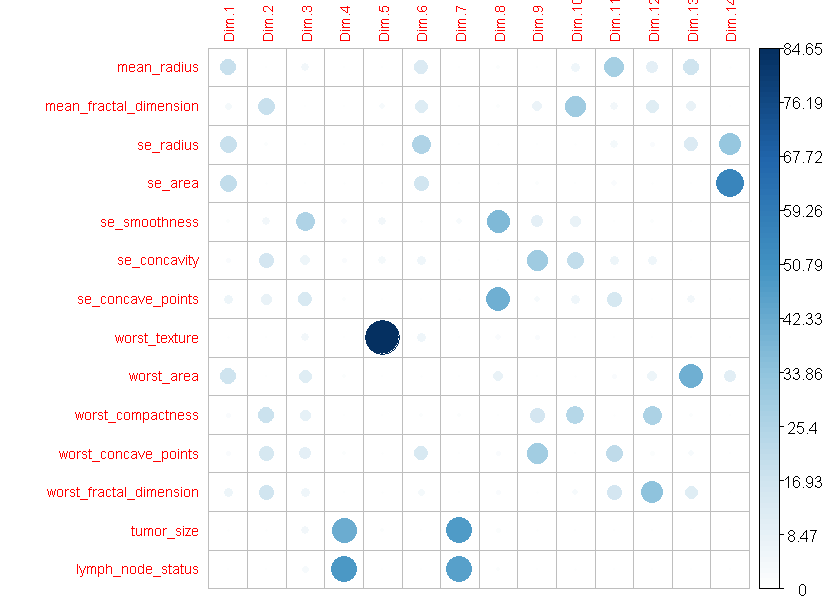

In [32]:
corrplot(all_var2$contrib, is.corr=FALSE, tl.cex = 0.7) 

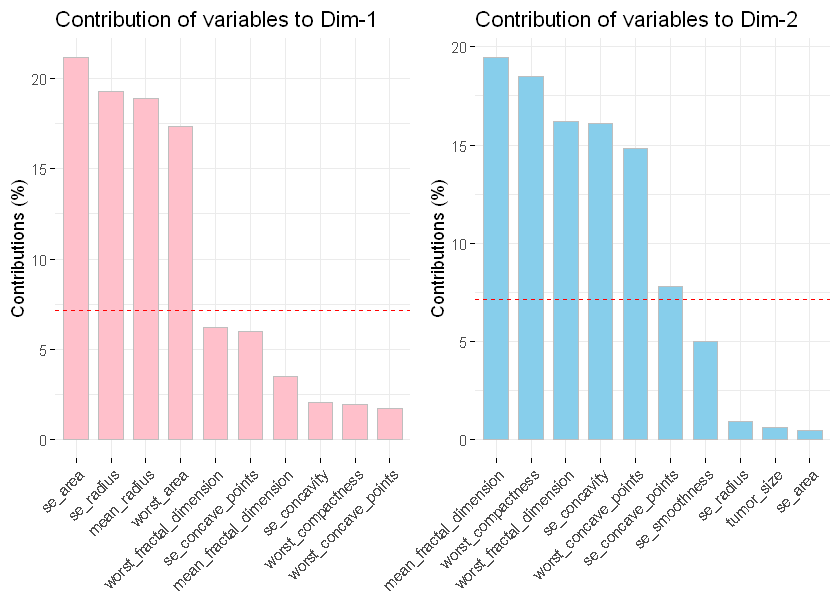

In [33]:
pp1 <- fviz_contrib(pca2, choice="var", axes=1, fill="pink", color="grey", top=10)
pp2 <- fviz_contrib(pca2, choice="var", axes=2, fill="skyblue", color="grey", top=10)
grid.arrange(pp1,pp2,ncol=2)

In [34]:
# Pour mesurer la proportion de variance expliquée
pca2_var <- pca2$sdev^2
pve2_df <- pca2_var / sum(pca2_var)
cum_pve2 <- cumsum(pve2_df)

cum_pve2

[1] 0.2843149 0.5285563 0.6680105 0.7725179 0.8435299 0.8893485 0.9239492
 [8] 0.9505034 0.9711661 0.9820173 0.9905204 0.9955190 0.9986466 1.0000000

En gardant toujours les trois première composantes principales, on explique presque 67% de la variance. 8 variables nous suffisent pour expliquer plus de 95% de la variance.

## Régression logistique - Modèle complet

In [35]:
wpbc_bis=wpbc%>%na.omit
wpbc_bis$outcome=ifelse(wpbc_bis$outcome=='N',0,1)
train <- sample(nrow(wpbc_bis), 0.7*nrow(wpbc_bis))
train_set <- wpbc_bis[train,]
test_set <- wpbc_bis[-train,]
library(MASS)
wpbc.full.glm=glm(outcome~.,data=wpbc_bis,family=binomial(link="logit"))

p <- predict(wpbc.full.glm, train_set, type = 'response')
p <- ifelse(p > 0.5, 1, 0)

print(paste('Précision sur le train-test :', mean(p == train_set$outcome)))

[1] "Précision sur le train-test : 0.888888888888889"


In [36]:
AIC.backward <- stepAIC(wpbc.full.glm,direction = "backward",trace=0)
AIC.both <- stepAIC(wpbc.full.glm,direction = "both",trace=0)

In [37]:
AIC.backward


Call:  glm(formula = outcome ~ time + mean_radius + mean_texture + mean_area + 
    mean_smoothness + mean_concave_points + mean_fractal_dimension + 
    se_radius + se_texture + se_perimeter + se_smoothness + se_compactness + 
    se_concavity + se_concave_points + se_symmetry + se_fractal_dimension + 
    worst_radius + worst_texture + worst_perimeter + worst_area + 
    worst_compactness + worst_concavity + worst_symmetry + lymph_node_status, 
    family = binomial(link = "logit"), data = wpbc_bis)

Coefficients:
           (Intercept)                    time             mean_radius  
               1.81809                -0.07282                -3.78483  
          mean_texture               mean_area         mean_smoothness  
              -0.43938                 0.03191               248.62955  
   mean_concave_points  mean_fractal_dimension               se_radius  
             -77.93696              -256.99757               -26.59235  
            se_texture            se_pe

In [38]:
AIC.both


Call:  glm(formula = outcome ~ time + mean_radius + mean_texture + mean_area + 
    mean_smoothness + mean_concave_points + mean_fractal_dimension + 
    se_radius + se_texture + se_perimeter + se_smoothness + se_compactness + 
    se_concavity + se_concave_points + se_symmetry + se_fractal_dimension + 
    worst_radius + worst_texture + worst_perimeter + worst_area + 
    worst_compactness + worst_concavity + worst_symmetry + lymph_node_status, 
    family = binomial(link = "logit"), data = wpbc_bis)

Coefficients:
           (Intercept)                    time             mean_radius  
               1.81809                -0.07282                -3.78483  
          mean_texture               mean_area         mean_smoothness  
              -0.43938                 0.03191               248.62955  
   mean_concave_points  mean_fractal_dimension               se_radius  
             -77.93696              -256.99757               -26.59235  
            se_texture            se_pe

Les deux méthodes 'backward' et 'both' renvoient le même modèle.

Le critère AIC nous fait garder 24 régresseurs sur les 31 variables explicatives initiales.
Le rayon moyen a été conservé mais pas le périmètre ni l'aire, comme on pouvait le deviner à cause de leur forte corrélation.

## Régression logistique - Modèle issu de l'analyse des corrélations

In [39]:
wpbc_bis2=wpbc2%>%na.omit
wpbc_bis2$outcome=ifelse(wpbc_bis2$outcome=='N',0,1)
train <- sample(nrow(wpbc_bis2), 0.7*nrow(wpbc_bis2))
train_set <- wpbc_bis2[train,]
test_set <- wpbc_bis2[-train,]
library(MASS)
wpbc2.full.glm=glm(outcome~.,data=wpbc_bis2,family=binomial(link="logit"))

p <- predict(wpbc2.full.glm, train_set, type = 'response')
p <- ifelse(p > 0.5, 1, 0)

print(paste('Précision sur le train-test', mean(p == train_set$outcome)))

[1] "Précision sur le train-test 0.777777777777778"


Il n'est pas étonnant de trouver un taux de précision inférieur au modèle complet : étant donné que l'on a retiré des variables, on diminue le pouvoir explicatif du modèle.

## Régression logistique - Modèle issu de l'ACP

Cette fois-ci, on régresse la variable `outcome`par l'ensemble des variables contenues dans nos directions principales lors de l'ACP :

In [55]:
wpbc_bis3=wpbc%>%na.omit
wpbc_bis3$outcome=ifelse(wpbc_bis3$outcome=='N',0,1)
train <- sample(nrow(wpbc_bis3), 0.7*nrow(wpbc_bis3))
train_set <- wpbc_bis3[train,]
test_set <- wpbc_bis3[-train,]
library(MASS)
wpbc3.full.glm=glm(outcome~ se_area + se_radius + mean_radius
                   + worst_area + mean_fractal_dimension + worst_compactness
                   + worst_fractal_dimension + se_concavity
                   + worst_concave_points + se_concave_points,data=wpbc_bis3,family=binomial(link="logit"))

p <- predict(wpbc3.full.glm, train_set, type = 'response')
p <- ifelse(p > 0.5, 1, 0)

print(paste('Précision sur le train-test', mean(p == train_set$outcome)))

[1] "Précision sur le train-test 0.785185185185185"


Les résultats ne sont pas significativement meilleurs qu'en gardant le modèle complet. On en déduite qu'il nous est certainement préférable de garder le modèle complet pour faire nos prédictions, même si cela peut causer de *l'overfitting* en raison du grand nombre de variables retenues.

## K-Means Clustering

In [56]:
set.seed(123)
wpbc<-na.omit(wpbc)
summary(wpbc)
head(wpbc)
nrows <- NROW(wpbc)
index <- sample(1:nrows, 0.7 * nrows)   ## on rééchantillone aléatoirement puis divise le dataset

train <- wpbc[index,]                   
test <- wpbc[-index,]                   

   id_number       outcome      time         mean_radius     mean_texture  
 Min.   :   8423   N:148   Min.   :  1.00   Min.   :10.95   Min.   :10.38  
 1st Qu.: 856176   R: 46   1st Qu.: 14.25   1st Qu.:15.05   1st Qu.:19.34  
 Median : 886471           Median : 39.50   Median :17.29   Median :21.80  
 Mean   :2013348           Mean   : 46.94   Mean   :17.40   Mean   :22.30  
 3rd Qu.: 927996           3rd Qu.: 73.00   3rd Qu.:19.58   3rd Qu.:24.78  
 Max.   :9411300           Max.   :125.00   Max.   :27.22   Max.   :39.28  
 mean_perimeter     mean_area      mean_smoothness   mean_compactness 
 Min.   : 71.90   Min.   : 361.6   Min.   :0.07497   Min.   :0.04605  
 1st Qu.: 98.16   1st Qu.: 702.5   1st Qu.:0.09390   1st Qu.:0.10985  
 Median :113.70   Median : 929.1   Median :0.10220   Median :0.13175  
 Mean   :114.78   Mean   : 969.1   Mean   :0.10277   Mean   :0.14264  
 3rd Qu.:129.65   3rd Qu.:1193.5   3rd Qu.:0.11138   3rd Qu.:0.17220  
 Max.   :182.10   Max.   :2250.0   Max.   

id_number,outcome,time,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,...,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,tumor_size,lymph_node_status
119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,...,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,...,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0
843786,R,77,12.75,15.29,84.60,502.7,0.11890,0.1569,0.1664,...,107.30,733.2,0.1706,0.4196,0.5999,0.1709,0.3485,0.11790,2.5,0


In [57]:
nrow(test)
nrow(train)

[1] 59

[1] 135

In [58]:
predict.kmeans <- function(newdata, object){
    centers <- object$centers
    n_centers <- nrow(centers)
    dist_mat <- as.matrix(dist(rbind(centers, newdata)))
    dist_mat <- dist_mat[-seq(n_centers), seq(n_centers)]
    max.col(-dist_mat)
}

In [60]:
library(caret)
library(plyr)
learn_kmeans <- kmeans(train[,-1], centers=2)


# sum((test$outcome=="R")) : cela sert à s'y retrouver dans le tableau ci-dessous
pre_kmeans <- predict.kmeans(test[,-1],learn_kmeans)
pre_kmeans <- ifelse(pre_kmeans == 1,"N","R")
pre_kmeans<-as.factor(pre_kmeans)
cm_kmeans <- confusionMatrix(pre_kmeans, test$outcome)
cm_kmeans

Warning message in storage.mode(x) <- "double":
"NAs introduits lors de la conversion automatique"

ERROR: Error in do_one(nmeth): NA/NaN/Inf dans un appel à une fonction externe (argument 1)


Les termes diagonaux de notre tableau à deux entrées représentent les prédictions correctes. On ne peut pas se satisfaire du degré de précision de notre algorithme de K-Means qui est ici très faible.

In [ ]:
wpbc2<-na.omit(wpbc2)
summary(wpbc2)
head(wpbc2)
nrows <- NROW(wpbc2)
index <- sample(1:nrows, 0.7 * nrows)   ## on rééchantillone aléatoirement puis divise le dataset

train2 <- wpbc2[index,]                   
test2 <- wpbc2[-index,]   

In [ ]:
learn_kmeans <- kmeans(train2[,-1], centers=2)


pre_kmeans <- predict.kmeans(test2[,-1],learn_kmeans)
pre_kmeans <- ifelse(pre_kmeans == 1,"N","R")
pre_kmeans<-as.factor(pre_kmeans)
cm_kmeans <- confusionMatrix(pre_kmeans, test2$outcome)
cm_kmeans

En prenant `wpbc2`, les résultats sont à peine meilleurs. Manifestement, l'algorithme K-Means ne se prête pas à notre jeu de données.

## Conclusion : 

Lors de ce TP, nous avons utilisé divers outils graphiques et statistiques afin de construire un modèle prédictif le plus fiable pour la classification de patients selon la variable `outcome`. 
Il se trouve que, pour un tel jeu de données, l'analyse graphique s'est révélée très utile car elle est riche en enseignements. Quant à l'analyse statistique plus poussé de notre jeu de données, les différents algorithmes implémentés ont rencontré un succès inégal : l'algorithme K-Means est inefficace, alors que la régression logistique sur le modèle complet atteint une précision d'environ 90%.
Par ailleurs, une autre approche intéressante de ce jeu de données aurait été de prédire le temps au bout duquel le patient est susceptible de voir son cancer refaire surface. Cela aurait conduit à l'implémentation d'algorithmes différents, du fait de la nature continue de la variable à prédire.